In [78]:
from Helpers import *

def Feedback_Linearization_with_Delay2(Duration = .6,w1 = 1e7,w2 = 1e7,w3 = 1e5,w4 = 1e5,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,alpha= 1e-1,Activate_Noise = False,ForceField = [0,0],ForceFieldSpan = [0,0],newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 600, ShowJ = False, ShowEstimate = False,Delay = .100):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)

    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    #Incorporation of delay r)

    A_Euler = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A_Euler[:Num_Var,:Num_Var] = A_basic
    A_Euler[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B_Euler = np.zeros(((kdelay+1)*Num_Var,2))
    B_Euler[:Num_Var] = B_basic

    Am = np.array([[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
    Bm = np.array([[0,0],[0,0],[1,0],[0,0],[0,0],[0,1],[0,0],[0,0]])

    

    Am,Bm = Matrix_Iteration(Am,Bm,dt)


    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = Am
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = Bm
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+Bm.T@S@Bm)@Bm.T@S@Am
        array_L[Num_iter-2-k] = L
        S = Am.T@S@(Am-Bm@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        F = ForceField if ((k*dt >= ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else np.array([0,0])
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,alpha,B,kdelay)
        #print(Omega_sens,Omega_measure)

        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
       
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(Bm.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        if ShowJ : J+= u.T@R@u
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        print(y[k]-H@zhat)
        x[:2] = np.array([zhat[0],zhat[3]])
        x[2:4] = np.array([zhat[1],zhat[4]])
        tempz = np.copy(A_Euler@zhat+B_Euler@v+ K@(y[k]-H@zhat))
        zhat = np.copy(A@zhat+B@v+ K@(y[k]-H@zhat))
        #for p in [0,1,2,3,4,5]:
        #    zhat[p] = tempz[p]
            
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))
        #new_x[0:2] = np.array([zhat[0],zhat[3]])
        #new_x[2:4] = np.array([zhat[1],zhat[4]])
        new_x[4:6] += dt*Kfactor*(u-x[4:6]+F)

        if Activate_Noise : new_x+=motor_noise[:6]
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-new_x[3]*(2*new_x[2]+new_x[3])*a2*np.sin(new_x[1]),new_x[2]*new_x[2]*a2*np.sin(new_x[1])])
        
        M = np.array([[a1+2*a2*cos(new_x[1]),a3+a2*cos(new_x[1])],[a3+a2*cos(new_x[1]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        J+= z.T@Q@z
        print("Total cost of FL: "+str(J)[:7])

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('viridis')(kdelay*4 / Num_iter)

    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = color1,label = "True movement with "+str(int(kdelay*dt*1000))+ " \n miliseconds delay",linewidth = .8)
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = .8,linestyle = "--")
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
    
    return X,Y

def Matrix_Iteration(A,B,dt):
    n, m = A.shape[0], B.shape[1]
    block_matrix = np.block([[A, B], [np.zeros((m, n)), np.zeros((m, m))]])
    
    return (expm(block_matrix * dt)[:n,:n]),(expm(block_matrix * dt)[:n,n:])

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-1.95458111e-05 -5.86374332e-03  2.22044605e-16  3.52626376e-05
  1.05787913e-02 -4.44089210e-16  0.00000000e+00  0.00000000e+00]
[-1.79418796e-05 -5.76974184e-03  1.04311579e-02  3.23689816e-05
  1.09884701e-02 -3.77326522e-02  0.00000000e+00  0.00000000e+00]
[-1.27775772e-05 -5.68551240e-03  1.82165366e-02  1.82099059e-05
  1.14531031e-02 -6.58421442e-02  0.00000000e+00  0.00000000e+00]
[-5.02364041e-06 -5.60852634e-03  2.37994276e-02 -4.19374552e-06
  1.19406764e-02 -8.57958674e-02  0.00000000e+00  0.00000000e+00]
[ 4.58299888e-06 -5.53184669e-03  2.75766920e-02 -3.24137518e-05
  1.24166474e-02 -9.89384094e-02  0.00000000e+00  0.00000000e+00]
[ 1.54364696e-05 -5.45004827e-03  2.98885839e-02 -6.4424863

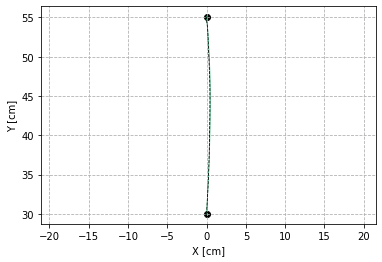

In [79]:
X,Y = Feedback_Linearization_with_Delay2(Num_iter=60,ForceField=[10,0],ForceFieldSpan=[.2,.2],ShowEstimate=True,alpha = 1)
#X,Y = Feedback_Linearization_with_Delay2(Num_iter=600,ForceField=[10,0],ForceFieldSpan=[.2,.22],ShowEstimate=True,alpha = 1)

-10.607262265802174 55.17313878225635


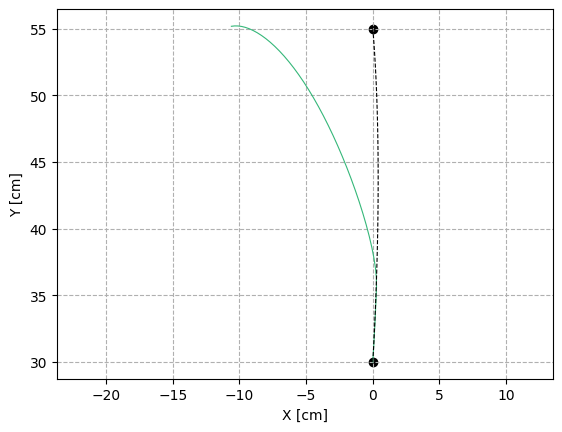

In [7]:
X,Y = Feedback_Linearization_with_Delay2(Num_iter=60,ForceField=[10,0],ForceFieldSpan=[.2,.22],ShowEstimate=True,alpha = 1)

0.10251464670442445 55.0369327792109


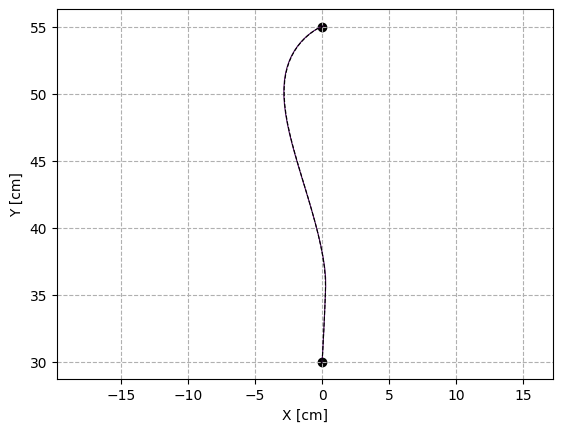

In [3]:
X,Y = Feedback_Linearization_with_Delay2(Num_iter=60,ForceField=[10,0],ForceFieldSpan=[.2,.22],ShowEstimate=True,alpha = 1e-2,Delay = 0)